# Y pseudo-alignment to determine founder donors

Imports.

In [1]:
import matplotlib.pyplot as plt # make simple visualizations
import numpy as np # data management
import pandas as pd # data management

import genotype_helpers # various helper functions & constants
from genotype_helpers import Genotypes # type hinting


This helper file uses:
Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)],
Matplotlib version 3.7.1, 
NumPy version 1.24.3,
pandas version 1.5.3, 
pyMSAviz version 0.4.0,
scikit-allel version 1.3.6



Prepare lists of IDs by Y haplotype.

In [2]:
y_groups = pd.read_csv(genotype_helpers.Y_GROUPS_FILE)
y1_ids = y_groups.loc[y_groups['Y_group'] == 'Y1 (ACI)', 'rfid']
y2_ids = y_groups.loc[y_groups['Y_group'] == 'Y2 (M520)', 'rfid']

Helper functions

In [3]:
def align_modern_where_founders_vary(founders: Genotypes, modern: Genotypes,
                                     haplotype: str, width: float) -> pd.Series:
    """Make and save a pseudo-alignment at SNPs where founders vary.

    At all SNPs where the founders have variation, find the most
    common allele among modern samples; this is the modern haplotype.
    The modern haplotype is pseudo-aligned above all founder samples.

    Entropy of the consensus haplotype at each position is plotted 
    in a bar chart which is meant to go above the pseudo-alignment.

    Parameters
    ----------
    founders: Genotypes
        Founder genotypes as a (samples x variants) shape data frame.
    modern: pd.DataFrame
        Modern genotypes as a (samples x variants) shape data frame.
    haplotype: str
        Name of this modern haplotype.
    width: float
        Width of the entropy plot (height is 1).
    
    Returns
    -------
    modern_consensus: pd.Series
        Consensus modern haplotype that was aligned.
    """

    # ---- pseudo-alignment ----

    # determine founder sequences at SNPs with variation
    founder_seqs = genotype_helpers.filter_maf(founders)
    vary_pos = founder_seqs.columns

    # determine modern consensus haplotype
    modern_consensus = modern[vary_pos].mode()
    modern_consensus.index = [f'{haplotype}(modern)']
    
    # put modern haplotype above founders
    genotype_helpers.plot_align(pd.concat((modern_consensus, founder_seqs)), 
                                basename = haplotype)
    genotype_helpers.save_plot(f'{haplotype}_align')

    # ---- entropy barchart ----

    def calc_entropy(vals):
        """Calculate Shannon entropy of biallelic SNP frequencies."""
        counts = vals.value_counts()
        freqs = counts / counts.sum()
        return np.log2(2) + sum((freqs * np.log2(freqs)))
    
    plt.figure(figsize = (width, 1))
    plt.bar(range(len(vary_pos)), modern[vary_pos].apply(calc_entropy))
    # bar chart has no labels
    plt.axis('off')

    genotype_helpers.save_plot(f'{haplotype}_entropy')

    return modern_consensus.iloc[0]

def plot_num_deviation(geno: Genotypes, haplotype: str) -> pd.Series:
    """Make and save a plot of deviations from the consensus.

    The plot show chromosome position on the X-axis and number of
    samples with a nonmissing mismatching genotype call.

    Parameters
    ----------
    gneo: Genotypes
        Genotypes as a (samples x variants) shape data frame.
    haplotype: str
        Name of this modern haplotype.
    
    Returns
    -------
    num_deviants: pd.Series
        Number of deviants for all SNPs with at least 10.
    """

    def count_deviants(vals):
        """Count mismatches to the consensus, ignoring missingness"""
        counts = vals.value_counts()
        return 0 if len(counts) == 1 else counts.min()
    
    num_deviants = geno.apply(count_deviants)

    plt.figure()
    plt.scatter(range(geno.shape[1]), num_deviants)
    plt.xticks([])

    plt.title(f'{haplotype} rats deviating from the consensus haplotype')
    plt.ylabel(f'Count of {haplotype} rats')

    genotype_helpers.save_plot(f'{haplotype}_mismatches')

    return num_deviants[num_deviants >= 10].rename('num_deviants')

Load genotypes as when making groups, but keep in SNPs with MAF=0. 
This retains variants which are fixed in modern samples.

In [4]:
y_shallow_modern = genotype_helpers.get_genotypes(
    genotype_helpers.SHALLOW_MODERN_FILE, 'Y', format = 'nucleotide',

    use_maf_filter = False
    )

Read 5227 variants across 15120 samples
7637 samples removed for not being male
Filtering out 300 variants for INFO score < 0.5
Filtering out 670 variants for % nonmissing calls < 75
Filtering out 10 samples for % nonmissing calls < 50
Genotypes for 7473 rats across 4257 variants


In [5]:
y_founders = genotype_helpers.get_genotypes(
    genotype_helpers.FOUNDERS_FILE, 'Y', format = 'nucleotide',
    
    variant_subset = y_shallow_modern.columns, 
    use_maf_filter = False, use_miss_filter = False
    )

Read 18499 variants across 8 samples
0 samples removed for not being male
14242 variants removed for not being in the given subset
Genotypes for 8 rats across 4257 variants


In [6]:
y_deep_modern = genotype_helpers.get_genotypes(
    genotype_helpers.DEEP_MODERN_FILE, 'Y', format = 'nucleotide',
    
    variant_subset = y_shallow_modern.columns, 
    use_maf_filter = False, use_miss_filter = False
    )

Read 22477 variants across 88 samples
44 samples removed for not being male
18270 variants removed for not being in the given subset
Genotypes for 44 rats across 4207 variants


Identify founder matches for Y1 rats. This is *Figure 1D*.

Filtering out 4232 variants for MAF=0


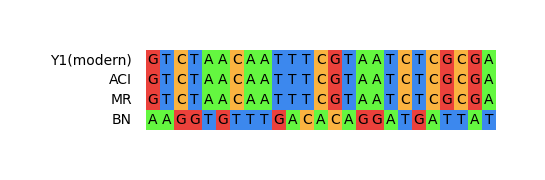

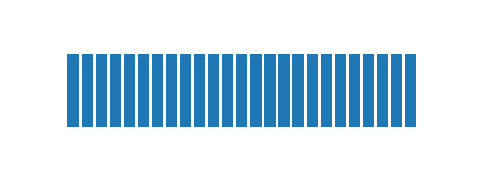

In [7]:
y1_shallow_consensus = align_modern_where_founders_vary(
    y_founders.loc[['ACI', 'MR', 'BN']], y_shallow_modern.loc[y1_ids], 
    haplotype = 'Y1', width = 4.95
    )

Check for significant devation from the consensus Y1 haplotype.

Series([], Name: num_deviants, dtype: int64)

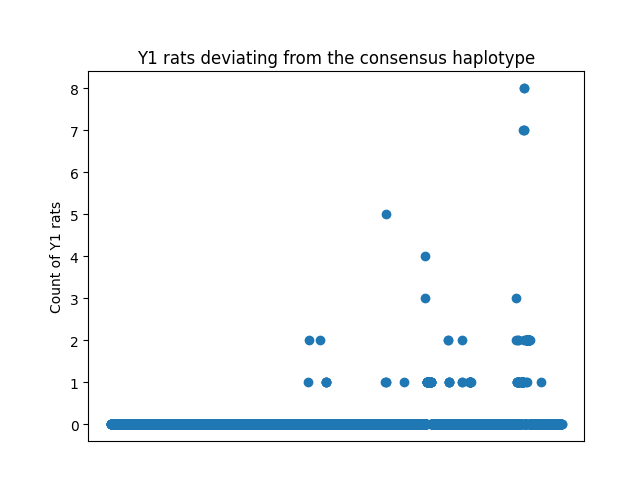

In [8]:
# Figure 1F
plot_num_deviation(y_shallow_modern.loc[y1_ids], haplotype = 'Y1')

In [9]:
y1_vary_cols = y1_shallow_consensus.index
y1_deep_modern = y_deep_modern.filter(y1_ids, axis = 'index')
y1_deep_consensus = y1_deep_modern[y1_vary_cols].mode().iloc[0]

print('Deep-sequenced Y1 haplotype at these SNPs matches shallow-sequenced:'\
      f' {all(y1_deep_consensus == y1_shallow_consensus)}')

print('Deep-sequenced Y1 haplotype at these SNPs has variation:'\
      f' {any(y1_deep_modern[y1_vary_cols].nunique() != 1)}')

print('SNPs where deep-sequenced Y1 samples have variation:')

y1_deep_modern.loc[:, y1_deep_modern.nunique() != 1]

Deep-sequenced Y1 haplotype at these SNPs matches shallow-sequenced: True
Deep-sequenced Y1 haplotype at these SNPs has variation: False
SNPs where deep-sequenced Y1 samples have variation:


,15473895
00077E7A63,A
00077EA7E6,A
000789FFAC,A
000789FFD3,A
000789FFF9,A
00078A0058,A
00078A00AC,A
00078A01C0,A
00078A01D8,A
00078A021A,A


Identify founder matches for Y2 rats. This is *Figure 1E*.

Filtering out 4240 variants for MAF=0


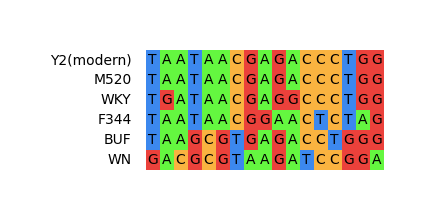

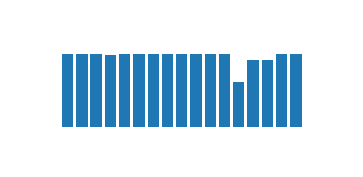

In [10]:
y2_shallow_consensus = align_modern_where_founders_vary(
    y_founders.loc[['M520', 'WKY', 'F344', 'BUF', 'WN']], 
    y_shallow_modern.loc[y2_ids], haplotype = 'Y2', width = 3.4
    )

Check for significant devation from the consensus Y2 haplotype.

8165793     88
8193120     11
14324036    15
Name: num_deviants, dtype: int64

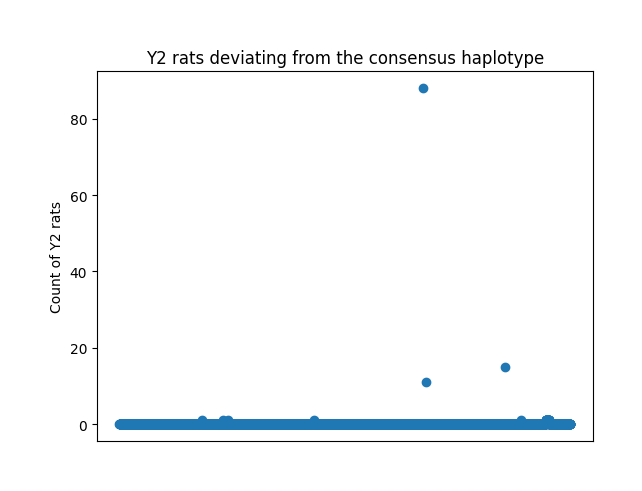

In [11]:
# Figure 1G
plot_num_deviation(y_shallow_modern.loc[y2_ids], 'Y2')

In [12]:
y2_vary_cols = y2_shallow_consensus.index
y2_deep_modern = y_deep_modern.filter(y2_ids, axis = 'index')

# deep-sequencing doesn't have all of these SNPs
shared_y2_vary_cols = y2_deep_modern.columns.intersection(y2_vary_cols)
y2_deep_consensus = y2_deep_modern[shared_y2_vary_cols].mode().iloc[0]

print('Deep-sequenced Y2 haplotype at these SNPs matches shallow-sequenced:'\
      f' {all(y2_deep_consensus == y2_shallow_consensus[shared_y2_vary_cols])}')

print('Deep-sequenced Y2 haplotype at these SNPs has variation:'\
      f' {any(y2_deep_modern[shared_y2_vary_cols].nunique() != 1)}')

print('SNPs where deep-sequenced Y2 samples have variation:')

y2_deep_modern.loc[:, y2_deep_modern.nunique() != 1]

Deep-sequenced Y2 haplotype at these SNPs matches shallow-sequenced: True
Deep-sequenced Y2 haplotype at these SNPs has variation: False
SNPs where deep-sequenced Y2 samples have variation:


,2270424,3868668
00077E67B5,C,C
00077E8336,G,C
000789FF7D,C,C
000789FF94,None,A
000789FFF0,C,C
00078A002C,None,None
00078A0215,C,C
00078A02CB,C,C
00078A09B1,C,C
00078A1707,C,C
